Recordemos primero las principales características de los Potenciales Evocados:

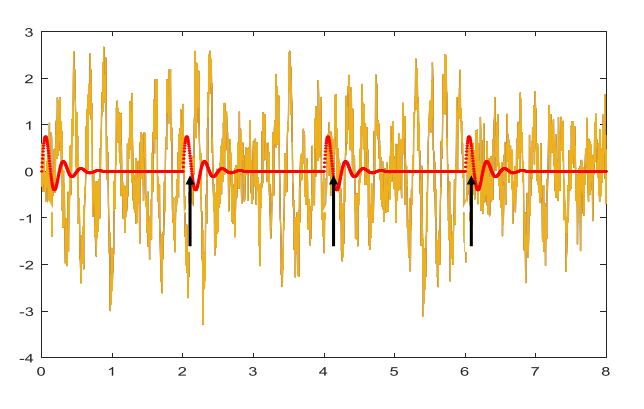

Las principales hipótesis que planteamos sobre los Potenciales Evocados son que cuentan con:
* Latencia característica
* Baja SNR (relación señal-ruido)
* Baja variabilidad intersujeto

En la primer parte vimos cómo obtener la forma característica de los Potenciales Evocados mediante la técnica de **Promediado Homogéneo**. Este caso lo usabamos cuando tengo la información de varias realizaciones en las que considero que el PE (*componente determinística*) tiene amplitud constante y el ruido en cada realización (el mar de EEG que es la *componente aleatoria*) es igual de "ruidoso" en cada realización. Había dos tipos de hacer este promediado: ordinario (el promedio que todxs conocemos comunmente) y exponencial (promediar de manera que voy a ir agarrando realización a realización y promedio iterativamente; que por eso nos sirve para hacer análisis online).

Ahora, en este Colab, vamos a ver el PROMEDIO INHOMOGÉNEO, el cual vamos a considerar que la amplitud de la señal y/o la varianza del EEG varía iteración a iteración.

---

Antes de arrancar, importemos las librerías que vamos a utilizar:

In [ ]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import scipy.io
import math as m

# PROMEDIO INHOMOGÉNEO

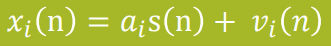

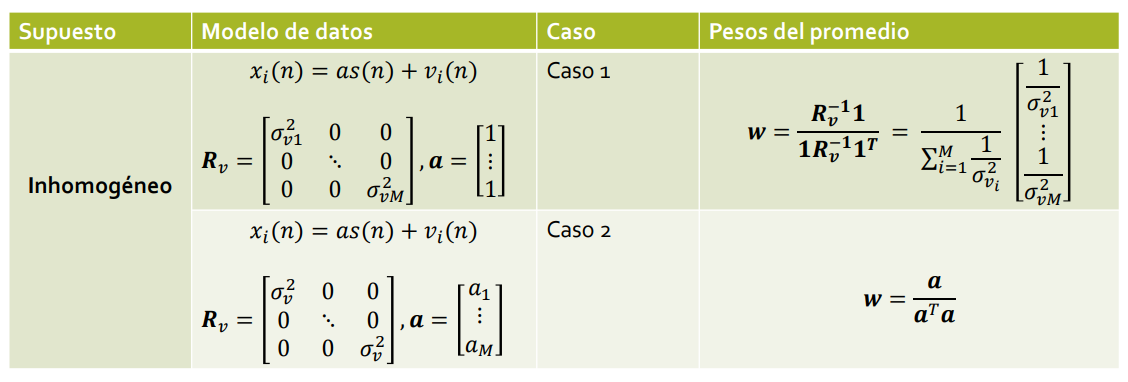

Agreguemos estos dos nuevos "casos" a nuesta función que genera realizaciones para poder probar nuestros nuevos algoritmos de promediado.

Para eso vamos a agregar un nuevo parámetro a la función llamado "`mode`" en el que vamos a poder elegir generar 4 tipos de potenciales:
1.  `homogeneo`: PE con la misma amplitud y el EEG de fondo con misma varianza
2.  `inhomogeneo1`: PE con distinta amplitud y el EEG de fondo con misma varianza
3.  `inhomogeneo2`: PE con la misma amplitud y el EEG de fondo con distinta varianza
4.  `inhomogeneo3`: PE con distinta amplitud y el EEG de fondo con distinta varianza

Antes de continuar quiero recordar que nosotros llamamos potencia a lo que va a "cambiar" la varianza del EEG de fondo; veamos a continuación un ejemplo de cómo los multiplicadores de la función `randn` son los encargados de variar la varianza del vector `sig1` y `sig2`.

In [ ]:
sig1 = 5 * np.random.randn(150)
sig2 = 25 * np.random.randn(150)

print(np.var(sig1), np.var(sig2))

24.914693281287647 523.4417047761476


Y por otro lado, vamos a usar `np.random.randn()` pero para generar un número aleatorio que sea el de la amplitud del PE o el de esa potencia del EEG de fondo, de la siguiente manera:

In [ ]:
abs(np.random.randn(1)[0])

1.0275804903611558

Ahora sí, agreguemos esos dos cambios a la función `realizaciones()`:

In [ ]:
def realizaciones(fs=250 , latencia=100, cant_pe=5, plotting = True , mode = 'homogeneo'):
  lat = latencia*(10**-3)*fs
  t_pe = np.linspace(0,0.2,int(fs*0.2))

  if mode == 'homogeneo' or mode == 'inhomogeneo2':
    pe = 20*np.sin(100*t_pe)*np.exp(-30*t_pe)
    pe = pe/np.max(pe)
    l = np.zeros([1,int(lat)])
    s = np.append(l,pe)
    end = np.zeros([1,fs-s.shape[0]])
    sig = np.append(s,end)
    potencial_evocado = sig.copy()
    eeg = []
    for i in range(cant_pe):
      eeg.append(potencial_evocado)
    eeg = np.array(eeg)

  elif mode == 'inhomogeneo1' or mode == 'inhomogeneo3':
    eeg = []
    for i in range(cant_pe):
      pe = (5+5*abs(np.random.randn(1)[0])) * np.sin(100*t_pe)*np.exp(-30*t_pe)
      l = np.zeros([1,int(lat)])
      s = np.append(l,pe)
      end = np.zeros([1,fs-s.shape[0]])
      sig = np.append(s,end)
      eeg.append(sig)
    eeg = np.array(eeg)
    eeg = eeg/(0.1*np.max(eeg))
    potencial_evocado = np.mean(eeg, axis=0)

  if mode == 'homogeneo' or mode == 'inhomogeneo1':
    for i in range(cant_pe):
      noise = 10*np.random.randn(sig.shape[0])
      eeg[i,:] = eeg[i,:] + noise
  elif mode == 'inhomogeneo2' or mode == 'inhomogeneo3':
    for i in range(cant_pe):
      noise = (2+5*abs(np.random.randn(1)[0])) * np.random.randn(sig.shape[0])
      eeg[i,:] = eeg[i,:] + noise

  t_eeg = np.linspace(0,eeg.shape[1]/fs, eeg.shape[1])

  if plotting:
    plt.figure(figsize=(10,5))
    for i in range(cant_pe):
      plt.plot(t_eeg, eeg[i]-i*50)
    plt.title('Realizaciones')
    plt.ylabel('Amplitud [uV]')
    plt.xlabel('Tiempo [s]')
    plt.show()

  return t_eeg, eeg, potencial_evocado

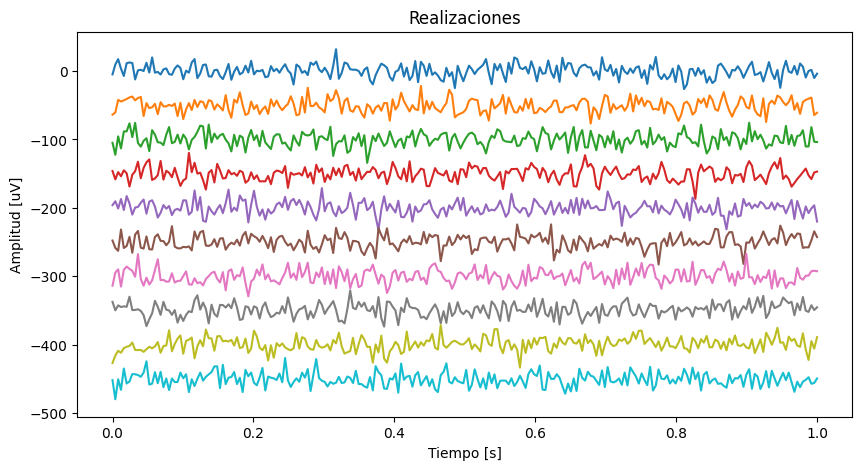

In [ ]:
_, _, _ = realizaciones(cant_pe = 10, mode='homogeneo')

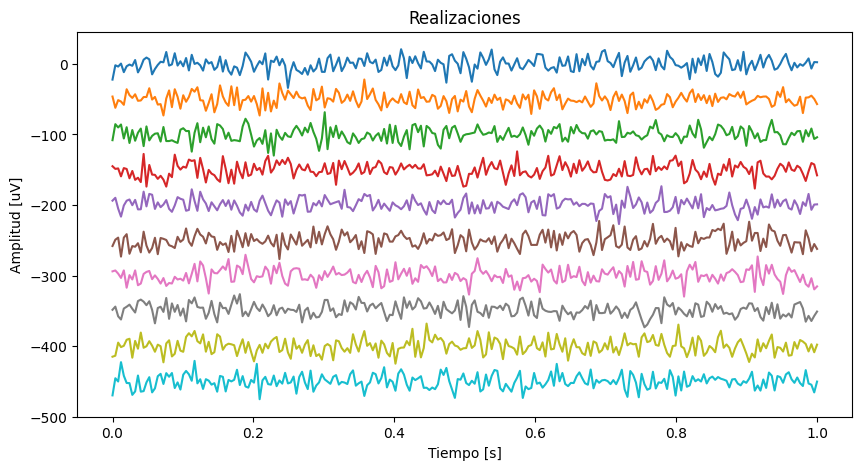

In [ ]:
_, _, _ = realizaciones(cant_pe=10, mode='inhomogeneo1')

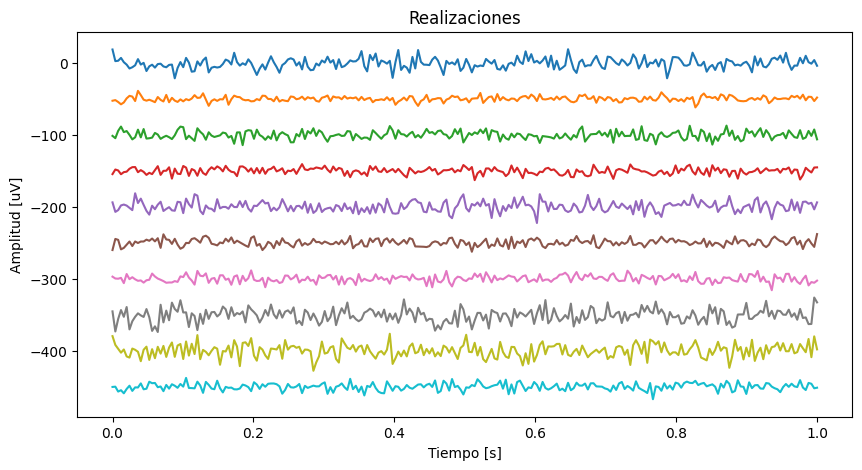

In [ ]:
_, _, _ = realizaciones(cant_pe=10, mode='inhomogeneo2')

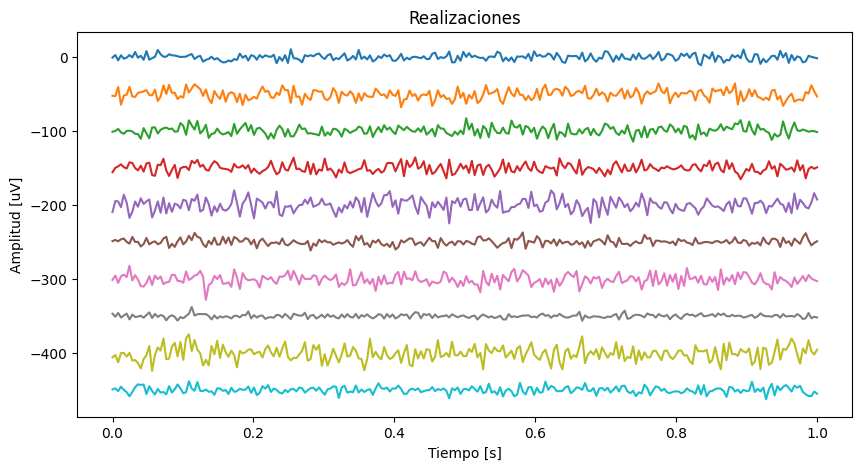

In [ ]:
_, _, _ = realizaciones(cant_pe=10, mode='inhomogeneo3')

## **CASO 1:** S variable

> La amplitud de la señal cambia en cada realización ($s(n)$ con amplitud $a_i$ variable):


> $x_i[n] = a_i s[n] + v_i[n]$

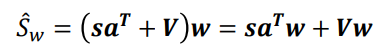

**ESTRATEGIA:** Calcular w tal que maximice la SNR del
promedio; entonces es un **problema de optimización**:

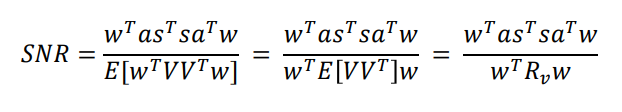

Restricciones:

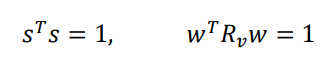

Entonces:

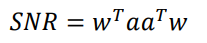

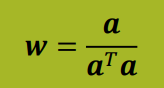

In [ ]:
t, x, pe = realizaciones(mode='inhomogeneo1', cant_pe = 200, plotting=False)

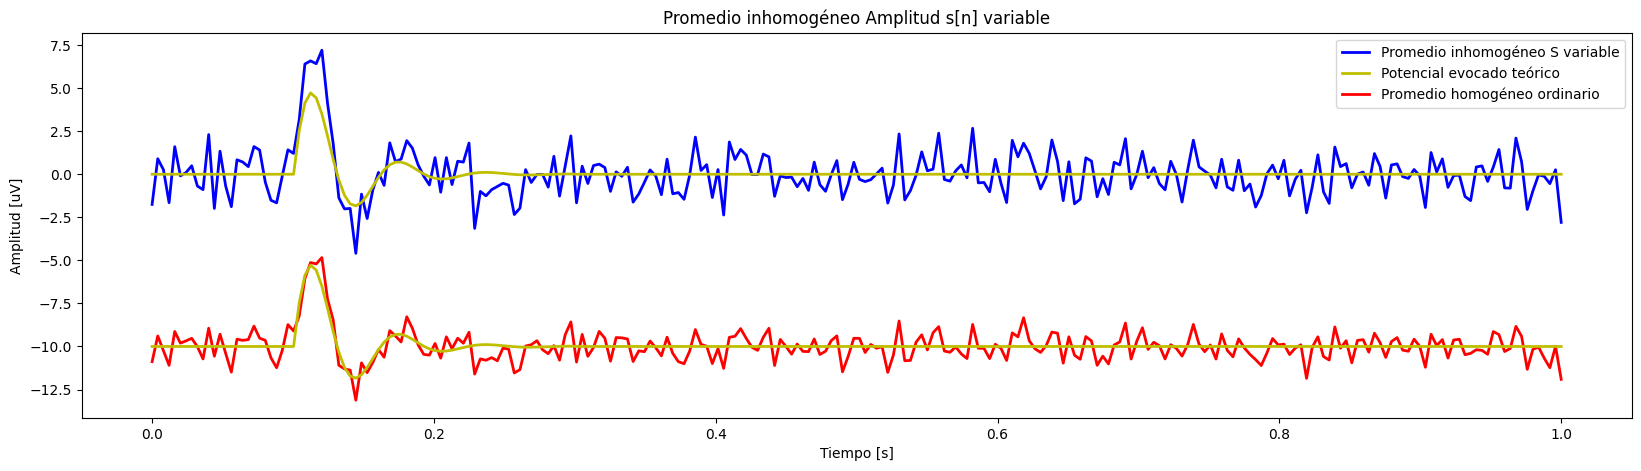

In [ ]:
# Estimo las amplitudes de los PEs en cada realizacion (a)
s = np.mean(x, axis = 0)
s_t = np.transpose(s)
a = x.dot(s_t)
a_t = np.transpose(a)

# Calculo los pesos del promedio ponderado para el Caso 1
w = a/(a_t.dot(a))
w_t = np.transpose(w)

# Estimo el promedio inhomogeneo
sp1 = w_t.dot(x/np.sum(w))

# Grafico
plt.figure(figsize = (20,5))
plt.plot(t, sp1, 'b', linewidth = 2, label='Promedio inhomogéneo S variable')
plt.plot(t,pe ,'y', label='Potencial evocado teórico',linewidth = 2)
plt.plot(t, np.mean(x, axis = 0)-10,'r', linewidth = 2, label='Promedio homogéneo ordinario')
plt.plot(t,pe-10,'y', linewidth = 2)
plt.title('Promedio inhomogéneo Amplitud s[n] variable')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [uV]')
plt.legend()
plt.show()

## **CASO 2:** V variable



>  Las varianzas del ruido en cada realización cambian




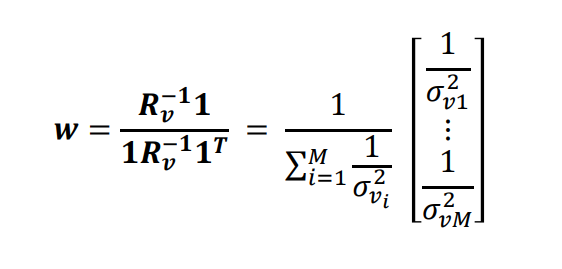

In [ ]:
t, x, pe = realizaciones(mode='inhomogeneo2', cant_pe = 250, plotting=False)

In [ ]:
### PROMEDIO INHOMOGENEO S VARIABLE

# Estimo las amplitudes de los PEs en cada realizacion (a)
s = np.mean(x, axis = 0)
s_t = np.transpose(s)
a = x.dot(s_t)
a_t = np.transpose(a)

# Calculo los pesos del promedio ponderado para el Caso 1
w = a/(a_t.dot(a))
w_t = np.transpose(w)

# Estimo el promedio inhomogeneo
sp1 = w_t.dot(x/np.sum(w))

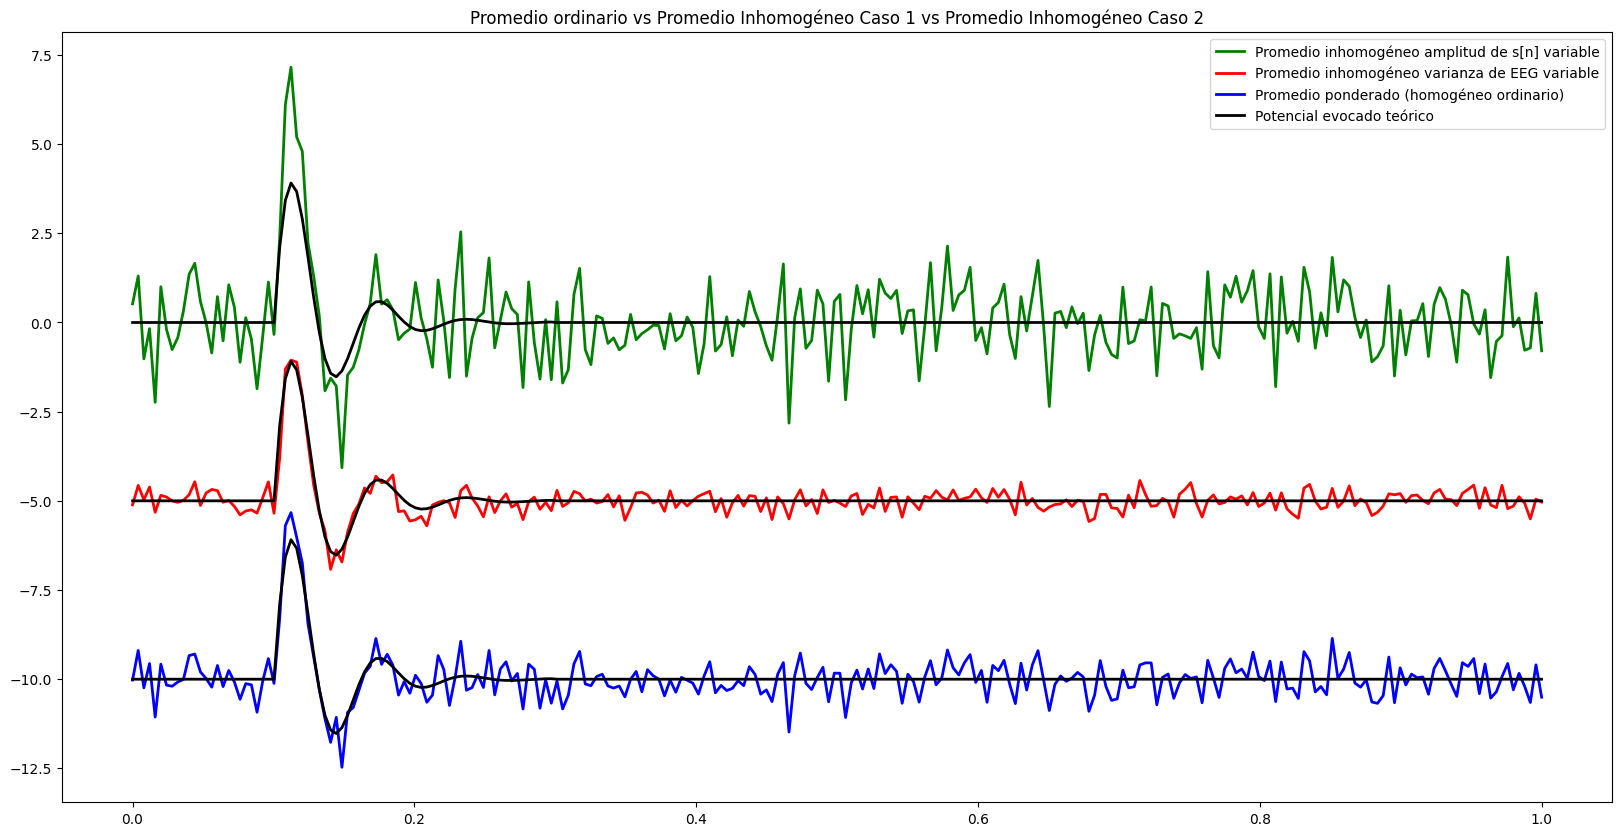

In [ ]:
### PROMEDIO INHOMOGENEO V VARIABLE

M = x.shape[0]
V = np.zeros([M,1])

# Estimo la varianza del ruido
for i in range(0,M):
  V[i] = np.var(x[i,:])

V_1 = 1/V
suma = np.sum(V_1)

# Obtengo los pesos del promedio ponderado
w = (1/suma)*(V_1)
w_t = np.transpose(w)

# Estimo el promedio inhomogeneo
sp2 = w_t.dot(x)
sp2 = np.transpose(sp2)

plt.figure(figsize = (20,10))
plt.plot(t,sp1,'green', linewidth=2, label='Promedio inhomogéneo amplitud de s[n] variable')
plt.plot(t,pe,'black',linewidth=2)
plt.plot(t,sp2-5,'r', linewidth=2, label='Promedio inhomogéneo varianza de EEG variable')
plt.plot(t,pe-5,'black',linewidth=2)
plt.plot(t,np.mean(x, axis = 0)-10,'b', linewidth=2, label='Promedio ponderado (homogéneo ordinario)')
plt.plot(t,pe-10,'black',linewidth=2, label='Potencial evocado teórico')
plt.title('Promedio ordinario vs Promedio Inhomogéneo Caso 1 vs Promedio Inhomogéneo Caso 2')
plt.legend(loc='upper right')
plt.show()